# Train model - No HyperDrive

In [ ]:
!pip install azureml-sdk[notebooks]
!pip install torch
!pip install torchvision
!pip install tensorflow
!pip install keras
!pip install keras.models 

In [9]:
# Imports
import torch
import torchvision
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [10]:
# Azure ML Imports
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Workspace, Experiment
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.widgets import RunDetails

## Workspace

In [11]:
ws = Workspace.from_config()
experiment_name = 'ASL-DeepLearning-hyperameter'

exp_with_hyper = Experiment(workspace=ws, name='Sign-Language-HyperDrive')
exp_no_hyper = Experiment(workspace=ws, name='Sign-Language-NoHyperDrive')


print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')


Workspace name: quick-starts-ws-135837
Azure region: southcentralus
Subscription id: 61c5c3f0-6dc7-4ed9-a7f3-c704b20e3b30
Resource group: aml-quickstarts-135837


## Compute

In [ ]:
# Choose a name for your CPU cluster
cluster_name = "gpu-cluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC24',
                                                           max_nodes=10)
    cpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

## Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [12]:
from azureml.data.dataset_factory import TabularDatasetFactory

# Create TabularDataset using TabularDatasetFactory
# Data is available at: 
# "https://www.kaggle.com/datamunge/sign-language-mnist"

found = False
key = "sign-language-mnist"
description_text = "sign Language MNIST"

if key in ws.datasets.keys(): 
    found = True
    ds = ws.datasets[key] 

if not found:
    from azureml.data.dataset_factory import TabularDatasetFactory
    datastore_path = "https://github.com/emanbuc/ASL-Recognition-Deep-Learning/raw/main/datasets/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv"
    ds = TabularDatasetFactory.from_delimited_files(path=datastore_path,header=True)       
    #Register Dataset in Workspace
    ds = ds.register(workspace=ws,name=key,description=description_text)

df = ds.to_pandas_dataframe()
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))
letters

## Data Preparation

In [13]:
targets = pd.get_dummies(df.pop('label')).values
data = df.values
targets.shape

(27455, 24)

In [14]:
data.shape

(27455, 784)

In [15]:
from sklearn.preprocessing import minmax_scale
data = minmax_scale(data)

In [16]:
input_shape = (28,28, 1) # 28*28 = 784

In [17]:
data = np.reshape(data,(-1, 28, 28,1))
data.shape

(27455, 28, 28, 1)

In [18]:
targets.shape

(27455, 24)

## SPLITTING THE DATA Training set and Validation Set

In [19]:
X_train, X_val, y_train, y_val = train_test_split(data, targets , test_size = 0.2, random_state=0)

### Save data to file for remote cluster

Salva i dati prepatati su file con pickle e esegue upload verso datastore del workspace in cloud.

In [ ]:
import pickle
import os
if os.path.isfile('dataset/sign-language-mnist.pkl'):
    print('File is present')
else:
    os.makedirs('dataset')
    with open('dataset/sign-language-mnist.pkl','wb') as f:
        pickle.dump((X_train,X_val,y_train,y_val),f)
    
    datastore=ws.get_default_datastore()
    datastore.upload('./dataset', target_path='sign-language-mnist-data')

print('Done')

## Remote Trainig Experiment

Create an estimator object to run training experiment in remote compute cluster

In [ ]:
from azureml.train.estimator import Estimator
script_params = {
    '--data_folder': ws.get_default_datastore(),
    '--hidden': 100
}

est = Estimator(source_directory='.',
                script_params=script_params,
                compute_target=cpu_cluster,
                entry_script='train_keras.py',
                pip_packages=['keras','tensorflow'])

In [ ]:

run = exp_no_hyper.submit(est)

## Remote Training with Hyper Drive

### Hyperdrive Configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

In [ ]:
from azureml.train.hyperdrive.policy import BanditPolicy,MedianStoppingPolicy
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform, normal,choice

In [ ]:
#TODO: Create the different params that you will be using during training
param_sampling = RandomParameterSampling({
         '--hidden': choice([50,100,200,300]),
         '--batch_size': choice([64,128]), 
         '--epochs': choice([3,5,10]),
         '--dropout': choice([0.5,0.8,1])})

In [ ]:
# TODO: Create an early termination policy. This is not required if you are using Bayesian sampling.

early_termination_policy = MedianStoppingPolicy()
hd_config = HyperDriveConfig(estimator=est,
  hyperparameter_sampling=param_sampling,
  policy=early_termination_policy,
  primary_metric_name='Accuracy',
  primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
  max_total_runs=16,
  max_concurrent_runs=10)

param_sampling = RandomParameterSampling({
         '--hidden': choice([50,100,200,300]),
         '--batch_size': choice([64,128]), 
         '--epochs': choice([5,10,50]),
         '--dropout': choice([0.5,0.8,1])})

In [ ]:
hyperdrive_run = exp_with_hyper.submit(hd_config)

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [ ]:
RunDetails(hyperdrive_run).show()
hyperdrive_run.wait_for_completion(show_output=True)

## Best Model

TODO: In the cell below, get the best model from the hyperdrive experiments and display all the properties of the model.

In [ ]:
assert(hyperdrive_run.get_status() == "Completed")
best_run = hyperdrive_run.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])
print(best_run.get_file_names())
best_run_metrics = best_run.get_metrics()
print('Best accuracy: {}'.format(best_run_metrics['Accuracy']))
print('========================')

In [ ]:
model = best_run.register_model(model_name='mnist_model.hdf5', model_path='./outputs/mnist_model.hdf5')

In [ ]:
model.download()

## Best Model Evaluation

In [6]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('./mnist_model.hdf5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4732)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               473300    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2424      
Total params: 476,004
Trainable params: 476,004
Non-trainable params: 0
__________________________________________________

In [21]:
score = model.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 99.98%


In [25]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis =1)
y_val = np.argmax(y_val, axis =1)

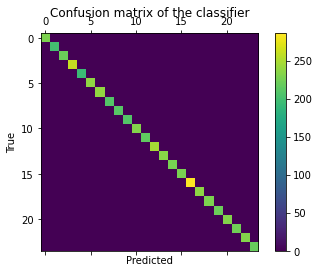

Accuracy :0.9998
Precision | Recall | F1 
0.9999 0.9998 0.9998


In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy :" + str(round(accuracy_score(y_val, y_pred),4)))
p, r, f, s = precision_recall_fscore_support(y_val, y_pred, average='macro')
print("Precision | Recall | F1 ")
print(round(p,4),round(r,4),round(f,4))